In [1]:
import pandas as pd
import numpy as np
import plotly as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import tree

pio.renderers.default = "browser"

<h3> Load the data from source </h3>

In [2]:
# pull shot data - note that this is from github - https://github.com/sealneaward/nba-movement-data

raw = pd.read_csv('data/shots_fixed.csv')
dropped = raw.drop(columns = ['EVENT_TYPE', 'GAME_EVENT_ID', 'GAME_DATE', 'GAME_ID'])

dropped.head(10)

,ACTION_TYPE,EVENTTIME,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,PLAYER_ID,PLAYER_NAME,...,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Jump Shot,215,Shot Chart Detail,LAL,-23.9825,157.0968,3,1,101138,Brandon Bass,...,15,0,218.50,2PT Field Goal,Center(C),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
1,Dunk Shot,191,Shot Chart Detail,LAL,224.3221,24.9662,3,1,101138,Brandon Bass,...,0,1,204.83,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
2,Jump Shot,518,Shot Chart Detail,LAL,-5.4122,173.0601,8,2,101138,Brandon Bass,...,16,1,520.65,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,OKC
3,Jump Shot,120,Shot Chart Detail,LAL,-25.9351,158.7570,2,3,101138,Brandon Bass,...,15,0,123.26,2PT Field Goal,Center(C),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
4,Jump Shot,646,Shot Chart Detail,LAL,178.3350,20.1712,10,1,201579,Roy Hibbert,...,15,1,650.49,2PT Field Goal,Right Side(R),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
5,Hook Shot,552,Shot Chart Detail,LAL,100.3073,98.9265,9,1,201579,Roy Hibbert,...,5,0,546.23,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
6,Hook Shot,430,Shot Chart Detail,LAL,111.9160,222.6307,7,1,201579,Roy Hibbert,...,4,0,449.90,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
7,Hook Shot,590,Shot Chart Detail,LAL,-92.6563,65.3523,9,3,201579,Roy Hibbert,...,5,0,593.22,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
8,Jump Shot,401,Shot Chart Detail,LAL,-216.1135,-10.5376,6,1,1626204,Larry Nance Jr.,...,13,1,408.84,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
9,Layup Shot,273,Shot Chart Detail,LAL,-219.9258,16.3056,4,2,1626204,Larry Nance Jr.,...,1,0,297.98,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC


Get the shots grouped by player in a dictionary

<h3> Compute the shooting average for each player </h3>

In [3]:

playerDict = {} # first is player name, second is their shots

# get list of ids
playerIds = dropped.PLAYER_ID.unique()

# make dictionary with empty arrays for each player's shots
for pid in playerIds:
    playerDict[pid] = []

# for each shot, add it to the player ID's array
for index, row in dropped.iterrows():
    innerPid = row['PLAYER_ID']
    shotMade = row['SHOT_MADE_FLAG']
    
    playerDict[innerPid].append(shotMade)

In [4]:
# try 2
playerAvgGrouped = dropped.groupby('PLAYER_ID', as_index=False)['SHOT_MADE_FLAG'].mean()
playerAverages = playerAvgGrouped.set_index(playerAvgGrouped['PLAYER_ID'])

In [5]:
shotAvgDict = {}

# get average of python list
def avg(l): 
    return sum(l) / len(l) 

for p in playerDict.keys():
    shotAvgDict[p] = avg(playerDict[p])
    
shotAvgDict

{np.int64(101138): 0.568,
 np.int64(201579): 0.45098039215686275,
 np.int64(1626204): 0.5616438356164384,
 np.int64(2555): 0.43333333333333335,
 np.int64(201586): 0.5083798882681564,
 np.int64(1626148): 0.2608695652173913,
 np.int64(201142): 0.5022421524663677,
 np.int64(202713): 0.4,
 np.int64(202683): 0.5697211155378487,
 np.int64(203527): 0.45614035087719296,
 np.int64(203135): 0.425,
 np.int64(977): 0.3492063492063492,
 np.int64(201571): 0.36231884057971014,
 np.int64(203500): 0.6148148148148148,
 np.int64(201566): 0.45132743362831856,
 np.int64(1626166): 0.41228070175438597,
 np.int64(203903): 0.44170403587443946,
 np.int64(1626156): 0.4250614250614251,
 np.int64(203460): 0.512,
 np.int64(201627): 0.41379310344827586,
 np.int64(203079): 0.38513513513513514,
 np.int64(101150): 0.40540540540540543,
 np.int64(1626273): 0.45161290322580644,
 np.int64(200779): 0.5,
 np.int64(203458): 0.4486486486486487,
 np.int64(201978): 0.4214876033057851,
 np.int64(203141): 0.43309859154929575,
 np.

In [6]:
# copy
full = dropped.sample(frac = 1)
full['PLAYER_AVG'] = ''

# add average -> This takes a bit for me. About 9 mins on my machine
# Will go to OH to try to speed it up, but until then, we can just use the outputted CSV 
for index, row in full.iterrows():
    full.loc[full['PLAYER_ID'] == row['PLAYER_ID'], 'PLAYER_AVG'] = shotAvgDict[row['PLAYER_ID']]

<h4> Load to csv so we don't have to rerun this every time </h4>

In [7]:
full.to_csv('fullDF.csv')

<h2> Data Analysis and ML </h2>

<h4> Get full csv </h4>

In [8]:
fullDF = pd.read_csv('fullDF.csv')

<h4> Drop irrelevant columns</h4>

In [9]:
# drop irrelevant columns
fullDF = fullDF.loc[:, ~fullDF.columns.str.contains('^Unnamed')]
fullDF.drop(columns = ['EVENTTIME', 'GRID_TYPE', 'PLAYER_ID', 'SHOT_ATTEMPTED_FLAG', 'TEAM_ID'], inplace = True)

<h4> Use entropy to find which columns to drop </h4>

First one hot encode and break into preliminary testing and training data

Now see likelihood of making a shot based on different correlations (this takes about 2 minutes on my machine)

In [10]:
# try with everything
categorical_cols = ['ACTION_TYPE', 'HTM', 'PERIOD', 'PLAYER_NAME', 'QUARTER', 'SHOT_TYPE', 'SHOT_ZONE_AREA',
                    'SHOT_ZONE_BASIC', 'SHOT_ZONE_RANGE', 'TEAM_NAME', 'VTM']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

featPrelim = onehot_encode(fullDF)
featPrelim

,LOC_X,LOC_Y,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,PLAYER_AVG,ACTION_TYPE_Alley Oop Dunk Shot,ACTION_TYPE_Alley Oop Layup shot,...,VTM_OKC,VTM_ORL,VTM_PHI,VTM_PHX,VTM_POR,VTM_SAC,VTM_SAS,VTM_TOR,VTM_UTA,VTM_WAS
0,43.7023,125.5702,1,3,23,0,57.11,0.378698,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.6433,58.2216,10,2,6,0,598.80,0.407583,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-104.2163,75.1707,10,4,2,0,587.33,0.452830,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.1123,55.9999,1,39,2,0,100.72,0.573585,False,False,...,False,False,False,False,False,False,False,False,False,False
4,124.0851,162.0297,1,44,18,0,106.68,0.493590,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84462,-190.7544,258.5428,0,23,0,0,21.09,0.637931,False,False,...,False,False,False,False,False,False,False,False,False,False
84463,154.8047,187.7722,9,49,23,1,592.20,0.445455,False,False,...,False,False,False,False,False,False,False,False,False,False
84464,92.4886,20.1129,9,10,8,1,553.37,0.455466,False,False,...,False,False,False,False,False,False,False,False,False,False
84465,-12.6015,204.3659,11,9,19,0,672.28,0.421348,False,False,...,False,False,False,True,False,False,False,False,False,False


In [11]:
correlation_df = featPrelim.corr()[['SHOT_MADE_FLAG']]
correlation_df.rename(columns={"SHOT_MADE_FLAG": "correlation_with_making_shot"}, inplace=True)
correlation_df

,correlation_with_making_shot
LOC_X,0.007481
LOC_Y,-0.036743
MINUTES_REMAINING,0.011510
SECONDS_REMAINING,0.010951
SHOT_DISTANCE,-0.187651
...,...
VTM_SAC,0.004892
VTM_SAS,0.003040
VTM_TOR,-0.004145
VTM_UTA,0.000401


Check for features that have a correlation above 0.03

In [12]:
relevant_cols = correlation_df.loc[correlation_df['correlation_with_making_shot'] >= 0.03]
relevant_cols

,correlation_with_making_shot
SHOT_MADE_FLAG,1.000000
PLAYER_AVG,0.120922
ACTION_TYPE_Alley Oop Dunk Shot,0.074933
ACTION_TYPE_Cutting Dunk Shot,0.082773
ACTION_TYPE_Cutting Finger Roll Layup Shot,0.038050
ACTION_TYPE_Cutting Layup Shot,0.085503
ACTION_TYPE_Driving Dunk Shot,0.072543
ACTION_TYPE_Driving Finger Roll Layup Shot,0.060802
ACTION_TYPE_Driving Layup Shot,0.076853
ACTION_TYPE_Dunk Shot,0.108120


From this, we gather that the most important features are the player's average, shot zone, shot distance, location, and action/shot type

In [13]:
dataset_imp_features_only = fullDF[['SHOT_MADE_FLAG', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE',
                                    'PLAYER_AVG', 'SHOT_TYPE', 'ACTION_TYPE', 'SHOT_DISTANCE', 'LOC_Y', 'LOC_X']]
dataset_imp_features_only

,SHOT_MADE_FLAG,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,PLAYER_AVG,SHOT_TYPE,ACTION_TYPE,SHOT_DISTANCE,LOC_Y,LOC_X
0,0,Right Corner 3,Right Side(R),24+ ft.,0.378698,3PT Field Goal,Jump Shot,23,125.5702,43.7023
1,0,In The Paint (Non-RA),Center(C),Less Than 8 ft.,0.407583,2PT Field Goal,Jump Shot,6,58.2216,1.6433
2,0,Restricted Area,Center(C),Less Than 8 ft.,0.452830,2PT Field Goal,Driving Reverse Layup Shot,2,75.1707,-104.2163
3,0,Restricted Area,Center(C),Less Than 8 ft.,0.573585,2PT Field Goal,Jump Shot,2,55.9999,0.1123
4,0,Mid-Range,Right Side Center(RC),16-24 ft.,0.493590,2PT Field Goal,Jump Shot,18,162.0297,124.0851
...,...,...,...,...,...,...,...,...,...,...
84462,0,Restricted Area,Center(C),Less Than 8 ft.,0.637931,2PT Field Goal,Tip Layup Shot,0,258.5428,-190.7544
84463,1,Above the Break 3,Right Side Center(RC),24+ ft.,0.445455,3PT Field Goal,Jump Shot,23,187.7722,154.8047
84464,1,Mid-Range,Right Side(R),8-16 ft.,0.455466,2PT Field Goal,Turnaround Hook Shot,8,20.1129,92.4886
84465,0,Mid-Range,Center(C),16-24 ft.,0.421348,2PT Field Goal,Jump Shot,19,204.3659,-12.6015


One hot encode again, but only on the important features

In [14]:
categorical_cols = ['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PLAYER_AVG', 'SHOT_TYPE', 'ACTION_TYPE']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

important_features_df = onehot_encode(dataset_imp_features_only)
important_features_df

,SHOT_MADE_FLAG,SHOT_DISTANCE,LOC_Y,LOC_X,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_Backcourt,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,...,ACTION_TYPE_Step Back Bank Jump Shot,ACTION_TYPE_Step Back Jump shot,ACTION_TYPE_Tip Dunk Shot,ACTION_TYPE_Tip Layup Shot,ACTION_TYPE_Turnaround Bank Hook Shot,ACTION_TYPE_Turnaround Bank shot,ACTION_TYPE_Turnaround Fadeaway Bank Jump Shot,ACTION_TYPE_Turnaround Fadeaway shot,ACTION_TYPE_Turnaround Hook Shot,ACTION_TYPE_Turnaround Jump Shot
0,0,23,125.5702,43.7023,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,6,58.2216,1.6433,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2,75.1707,-104.2163,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,0,2,55.9999,0.1123,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,0,18,162.0297,124.0851,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84462,0,0,258.5428,-190.7544,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
84463,1,23,187.7722,154.8047,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
84464,1,8,20.1129,92.4886,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
84465,0,19,204.3659,-12.6015,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


<h4> Data Exploration and graphs </h4>

In [15]:
smallSamp = dropped.loc[dropped['PLAYER_ID'] == 201939]
medSamp = dropped.sample(3000)

In [16]:
fig = px.scatter(medSamp, x='LOC_X',  y='LOC_Y', color = 'SHOT_MADE_FLAG')
fig.show()

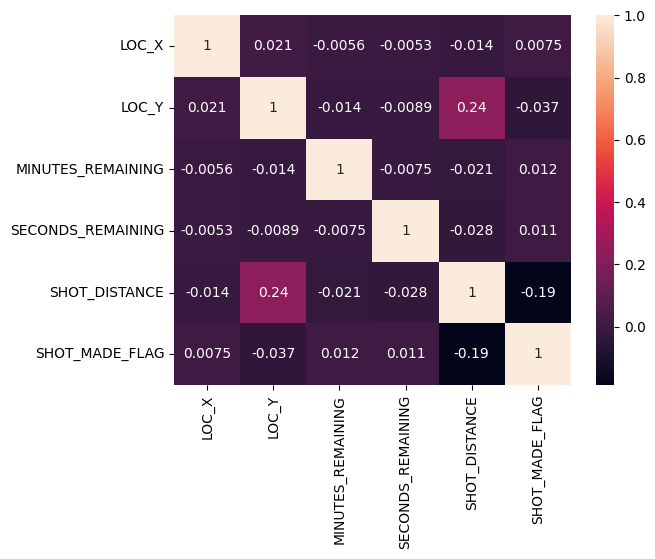

In [17]:
droppedImportant = dropped.drop(columns = ['EVENTTIME', 'PERIOD', 'QUARTER', 'SHOT_ATTEMPTED_FLAG', 'PLAYER_ID', 'TEAM_ID', 'SHOT_TIME'])
# Select only numeric columns for correlation
numeric_cols = droppedImportant.select_dtypes(include=[np.number])
cm = numeric_cols.corr()
sn.heatmap(cm, annot=True)
plt.show()

<h4> Separate target and features</h4>

In [18]:
# try with everything
categorical_cols = ['ACTION_TYPE', 'HTM', 'PERIOD', 'PLAYER_NAME', 'QUARTER', 'SHOT_TYPE', 'SHOT_ZONE_AREA',
                    'SHOT_ZONE_BASIC', 'SHOT_ZONE_RANGE', 'TEAM_NAME', 'VTM']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

fullDFOHE = onehot_encode(fullDF)

target = fullDFOHE['SHOT_MADE_FLAG']
features = fullDFOHE.drop(columns = ['SHOT_MADE_FLAG'])

sample = fullDFOHE.sample(20000, random_state = 4400)
targetSmall = sample['SHOT_MADE_FLAG']
featuresSmall = sample.drop(columns = ['SHOT_MADE_FLAG'])

# check to make sure that we have a decently representative sample
print("Sample percentage made", sum(targetSmall)/len(targetSmall))
print("Actual percentage made:", sum(fullDF['SHOT_MADE_FLAG']/len(fullDF['SHOT_MADE_FLAG'])))

Sample percentage made 0.44555
Actual percentage made: 0.4483052553068062


In [19]:
# try with just important features
targetImp = important_features_df['SHOT_MADE_FLAG']
featuresImp = important_features_df.drop(columns = ['SHOT_MADE_FLAG'])

impFeaturesSmall = important_features_df.sample(20000, random_state = 4400)
targetImpSmall = impFeaturesSmall['SHOT_MADE_FLAG']
featuresImpSmall = impFeaturesSmall.drop(columns = ['SHOT_MADE_FLAG'])

# check to make sure that we have a decently representative sample
print("Sample percentage made", sum(targetImpSmall)/len(targetImpSmall))
print("Actual percentage made:", sum(fullDF['SHOT_MADE_FLAG']/len(fullDF['SHOT_MADE_FLAG'])))

Sample percentage made 0.44555
Actual percentage made: 0.4483052553068062


<h4> Split </h4> 

In [20]:
# split with just the important features
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(featuresImp, targetImp, test_size=0.25, random_state = 4400) 
X_train_imp_small, X_test_imp_small, y_train_imp_small, y_test_imp_small = train_test_split(featuresImpSmall, targetImpSmall, test_size=0.25, random_state = 4400) 

In [21]:
# split with everything 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state = 4400) 
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(featuresSmall, targetSmall, test_size=0.25, random_state = 4400)

In [22]:
# make classifier and fit it
decisionTree = tree.DecisionTreeClassifier(max_depth = 2, random_state = 4400)
decisionTree = decisionTree.fit(X_train, y_train)

print("Decision tree made")

# make random forest classifiers
randomForest = RandomForestClassifier(n_estimators=5, random_state=4400)
randomForest.fit(X_train, y_train)

print("Random Forest made")

# make adaboost
adaboost = AdaBoostClassifier(n_estimators=15, random_state=4400)
adaboost.fit(X_train, y_train)

print("Adaboost done")

loc = [decisionTree, randomForest, adaboost]

print("Complete")

Decision tree made
Random Forest made
Adaboost done
Complete


In [23]:
# predict the classifications

for c in loc:    
    trainPredic = c.predict(X_train)
    trainAcc = c.score(X_train, y_train)
    precisionTrain, recallTrain, fScoreTrain, supportTrain = precision_recall_fscore_support(y_train, trainPredic)
    testPredic = c.predict(X_test)
    testAcc = c.score(X_test, y_test)
    precisionTest, recallTest, fScoreTest, supportTest = precision_recall_fscore_support(y_test, testPredic)
    
    print("\n-------------------------------------------------\n Estimator: %s" % (c))
    print("Train accuracy: %s" %  (trainAcc))
    print("Precision for training: %s" % (precisionTrain[0]))
    print("Recall for training: %s" % (recallTrain[0]))
    print("F1 for training: %s" % (fScoreTrain[0]))
    print("\n-------------------------------------------------\n")
    print("Test accuracy: %s" % (testAcc))
    print("Precision for testing: %s" % (precisionTest[0]))
    print("Recall for testing: %s" % (recallTest[0]))
    print("F1 for testing: %s" % (fScoreTest[0]))


-------------------------------------------------
 Estimator: DecisionTreeClassifier(max_depth=2, random_state=4400)
Train accuracy: 0.6200789265982636
Precision for training: 0.6765127803860198
Recall for training: 0.5946240256762952
F1 for training: 0.6329306979014153

-------------------------------------------------

Test accuracy: 0.6220107022777857
Precision for testing: 0.6810311284046693
Recall for testing: 0.5981715652768285
F1 for testing: 0.6369177583697234

-------------------------------------------------
 Estimator: RandomForestClassifier(n_estimators=5, random_state=4400)
Train accuracy: 0.957553275453828
Precision for training: 0.9547598203947926
Recall for training: 0.9688502980284274
F1 for training: 0.9617534527145234

-------------------------------------------------

Test accuracy: 0.6060519960221622
Precision for testing: 0.6342508130403745
Recall for testing: 0.6831852358168148
F1 for testing: 0.6578092221628069

-------------------------------------------------

In [24]:
def adaBoostOptimizer(loEst, xtr, ytr, xte, yte):
    testAccDict = {}
    
    for i in loEst:
        # make adaboost
        adaboost = AdaBoostClassifier(n_estimators = i, random_state=4400)
        adaboost.fit(xtr, ytr)
        adaboost.predict(xte)
        testAcc = adaboost.score(xte, yte)
        testAccDict[i] = testAcc
        print("Test acc for %s: %s" % (i, testAcc))
    
    return testAccDict

In [25]:
# this is for just the important features
loValsSpec = range(1,51)
adaDictSpecSmall = adaBoostOptimizer(loValsSpec, X_train_imp_small, y_train_imp_small, X_test_imp_small, y_test_imp_small)

Test acc for 1: 0.6302
Test acc for 2: 0.6302
Test acc for 3: 0.6336
Test acc for 4: 0.6336
Test acc for 5: 0.6336
Test acc for 6: 0.6336
Test acc for 7: 0.6336
Test acc for 8: 0.6336
Test acc for 9: 0.6336
Test acc for 10: 0.6336
Test acc for 11: 0.6336
Test acc for 12: 0.6342
Test acc for 13: 0.6336
Test acc for 14: 0.6342
Test acc for 15: 0.6342
Test acc for 16: 0.6342
Test acc for 17: 0.6342
Test acc for 18: 0.6342
Test acc for 19: 0.6342
Test acc for 20: 0.6342
Test acc for 21: 0.6342
Test acc for 22: 0.6342
Test acc for 23: 0.6342
Test acc for 24: 0.6342
Test acc for 25: 0.6342
Test acc for 26: 0.6342
Test acc for 27: 0.6342
Test acc for 28: 0.6342
Test acc for 29: 0.6342
Test acc for 30: 0.6342
Test acc for 31: 0.6342
Test acc for 32: 0.6342
Test acc for 33: 0.6342
Test acc for 34: 0.6342
Test acc for 35: 0.6342
Test acc for 36: 0.6342
Test acc for 37: 0.6342
Test acc for 38: 0.6342
Test acc for 39: 0.6342
Test acc for 40: 0.6342
Test acc for 41: 0.6342
Test acc for 42: 0.6342
T

In [26]:
# this is for the full dataset
# this is for just the important features
loValsSpec = range(1,51)
adaDictSpec = adaBoostOptimizer(loValsSpec, X_train, y_train, X_test, y_test)

Test acc for 1: 0.6220107022777857
Test acc for 2: 0.6220107022777857
Test acc for 3: 0.6369749490931477
Test acc for 4: 0.6324762040062509
Test acc for 5: 0.6324762040062509
Test acc for 6: 0.6357910688071222
Test acc for 7: 0.6369749490931477
Test acc for 8: 0.6395794857224038
Test acc for 9: 0.6395794857224038
Test acc for 10: 0.6395321305109627
Test acc for 11: 0.6395794857224038
Test acc for 12: 0.6395321305109627
Test acc for 13: 0.6395794857224038
Test acc for 14: 0.640100393048255
Test acc for 15: 0.640147748259696
Test acc for 16: 0.640100393048255
Test acc for 17: 0.640147748259696
Test acc for 18: 0.640100393048255
Test acc for 19: 0.640147748259696
Test acc for 20: 0.640100393048255
Test acc for 21: 0.640147748259696
Test acc for 22: 0.640147748259696
Test acc for 23: 0.640100393048255
Test acc for 24: 0.640147748259696
Test acc for 25: 0.640100393048255
Test acc for 26: 0.640147748259696
Test acc for 27: 0.640100393048255
Test acc for 28: 0.640147748259696
Test acc for 29:

Plot the graph to find a peak

In [27]:
# this is the graph for the small dataframe
adaSpecDfSmall = pd.DataFrame(adaDictSpecSmall, index = range(1, 51)).T
adaSpecDfSmall["estimators"] = adaSpecDfSmall.index
adaSpecDfSmall = adaSpecDfSmall.rename(columns = {1 : "accuracy"})

In [28]:
# this is the graph for the full dataframe
adaSpecDf = pd.DataFrame(adaDictSpec, index = range(1, 51)).T
adaSpecDf["estimators"] = adaSpecDf.index
adaSpecDf = adaSpecDf.rename(columns = {1 : "accuracy"})

In [29]:
# sample dataframe graph
figAB = px.line(adaSpecDfSmall, x = 'estimators', y = 'accuracy', 
                title="AdaBoost estimators and accuracy - Sample DF")
figAB.show()

In [30]:
# full dataframe graph
figAB = px.line(adaSpecDf, x = 'estimators', y = 'accuracy', 
                title="AdaBoost estimators and accuracy - Full DF")
figAB.show()

The sample has a peak around 32 estimators, and the full dataframe has its peak accuracy around 44 to 50.

In [31]:
def getABStats(nEstList, xtr, ytr, xte, yte):
    for nEst in nEstList:
        adaboost = AdaBoostClassifier(n_estimators = nEst, random_state=4400)
        adaboost.fit(X_train, y_train)
        trainPredic = adaboost.predict(X_train)
        trainAcc = adaboost.score(X_train, y_train)
        precisionTrain, recallTrain, fScoreTrain, supportTrain = precision_recall_fscore_support(y_train, trainPredic)
        testPredic = adaboost.predict(X_test)
        testAcc = adaboost.score(X_test, y_test)
        precisionTest, recallTest, fScoreTest, supportTest = precision_recall_fscore_support(y_test, testPredic)
        print("\n-------------------------------------------------\n%s Estimators:\nTrain accuracy for %s estimators: %s" % (nEst, nEst, trainAcc))
        print("Train error for %s estimators: %s" % (nEst, 1 - trainAcc))
        print("Precision for training: %s" % (precisionTrain[0]))
        print("Recall for training: %s" % (recallTrain[0]))
        print("F1 for training: %s" % (fScoreTrain[0]))
        print("\n-------------------------------------------------\n")
        print("Test accuracy for %s estimators: %s" % (nEst, testAcc))
        print("Test error for %s estimators: %s" % (nEst, 1 - testAcc))
        print("Precision for testing: %s" % (precisionTest[0]))
        print("Recall for testing: %s" % (recallTest[0]))
        print("F1 for testing: %s" % (fScoreTest[0]))

In [32]:
getABStats([10, 25, 44, 50], X_train, y_train, X_test, y_test)


-------------------------------------------------
10 Estimators:
Train accuracy for 10 estimators: 0.6385477505919495
Train error for 10 estimators: 0.36145224940805054
Precision for training: 0.6514210712302488
Recall for training: 0.739569005043558
F1 for training: 0.6927020425691817

-------------------------------------------------

Test accuracy for 10 estimators: 0.6395321305109627
Test error for 10 estimators: 0.3604678694890373
Precision for testing: 0.6553530751708428
Recall for testing: 0.7374401913875598
F1 for testing: 0.6939776473426067

-------------------------------------------------
25 Estimators:
Train accuracy for 25 estimators: 0.6391318074191003
Train error for 25 estimators: 0.36086819258089975
Precision for training: 0.652206905273808
Recall for training: 0.7389099037138928
F1 for training: 0.6928564710940334

-------------------------------------------------

Test accuracy for 25 estimators: 0.640100393048255
Test error for 25 estimators: 0.35989960695174505
Pr

This did best with 50 estimators. Let's see how we did based on where the player is shooting.

In [33]:
# adaboost with 50 estimators
adaboost = AdaBoostClassifier(n_estimators = 50, random_state=4400)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(random_state=4400)

In [34]:
# i checked this error and we were fine in this cell, get rid of the warning and put it back when we are done
pd.options.mode.chained_assignment = None

testPredic = adaboost.predict(X_test)

# new dataframe with locations, we will add predictions later
predicDF = X_test[["LOC_X", "LOC_Y", 'SHOT_DISTANCE']]
predicDF['SHOT_MADE_PREDICTION'] = testPredic
predicDF['SHOT_MADE_FLAG'] = y_test
predicDF['correct'] = 0

for index, row in predicDF.iterrows():
    predic = row['SHOT_MADE_PREDICTION']
    actual = row['SHOT_MADE_FLAG']
    
    # 0 by default
    correctVal = 0
    
    # change to 1 if we were right
    if predic == actual:
        correctVal = 1
    
    predicDF.at[index, 'correct'] = correctVal

pd.options.mode.chained_assignment = 'warn'

# check we have the right accuracy
print(sum(predicDF['correct'])/ len(predicDF))

predicDF

0.640100393048255


,LOC_X,LOC_Y,SHOT_DISTANCE,SHOT_MADE_PREDICTION,SHOT_MADE_FLAG,correct
17634,-136.9567,70.9527,16,1,0,0
57791,-37.5379,116.6653,9,1,0,0
73687,75.2027,196.9833,19,0,0,1
29200,-138.1074,204.0005,24,0,0,1
39402,122.0955,176.4795,20,0,0,1
...,...,...,...,...,...,...
1951,148.4422,188.8226,25,0,0,1
5740,-224.1682,6.6582,23,0,1,0
26876,-56.8755,10.4922,5,1,0,0
48856,-56.1194,253.0004,24,0,0,1


In [35]:
testSamp = predicDF.sample(1000, random_state = 4400)
testFig = px.scatter(testSamp, x='LOC_X',  y='LOC_Y', color = testSamp['correct'].map({0: 'red', 1: 'blue'}))
testFig.show()

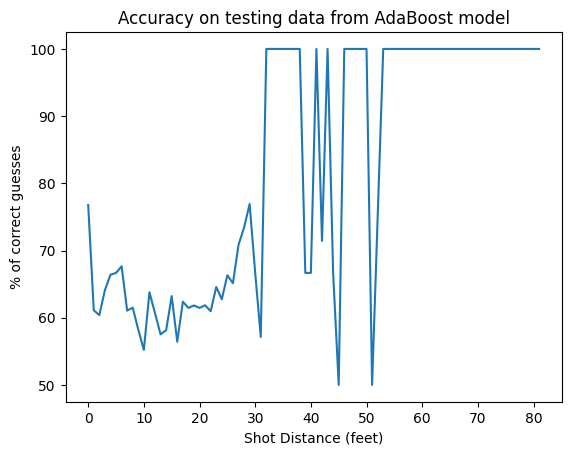

In [36]:
orgByDistance = predicDF.groupby('SHOT_DISTANCE')['correct'].mean()
attemptsByDistance = predicDF.groupby('SHOT_DISTANCE')['SHOT_MADE_FLAG'].count()

xVal = orgByDistance.index
yPer = orgByDistance.values * 100

plt.plot(xVal, yPer)
plt.xlabel('Shot Distance (feet)')
plt.ylabel('% of correct guesses')
plt.title('Accuracy on testing data from AdaBoost model')
plt.show()

In [37]:
predicDFUnder31 = predicDF[predicDF['SHOT_DISTANCE'] < 32]

for x in range(1, 40):
    predicDFUnderX = predicDF[predicDF['SHOT_DISTANCE'] < x]
    print("Under" , x, "feet", sum(predicDFUnderX['correct'])/ len(predicDFUnderX))

# accuracy now
# print(sum(predicDFUnder31['correct'])/ len(predicDFUnder31))
predicDFUnder31

Under 1 feet 0.7678654834189631
Under 2 feet 0.6874431301182894
Under 3 feet 0.6645203896318309
Under 4 feet 0.6621601545089882
Under 5 feet 0.6622873738072189
Under 6 feet 0.6625599792504214
Under 7 feet 0.6633663366336634
Under 8 feet 0.6607080673244341
Under 9 feet 0.6587425016662963
Under 10 feet 0.6559922887437079
Under 11 feet 0.6524888750905515
Under 12 feet 0.6520647041093137
Under 13 feet 0.650382122472671
Under 14 feet 0.6479955039340577
Under 15 feet 0.6457334177902452
Under 16 feet 0.6451668833983528
Under 17 feet 0.6410699588477367
Under 18 feet 0.6401810802372776
Under 19 feet 0.638860103626943
Under 20 feet 0.6379176379176379
Under 21 feet 0.6371524219443875
Under 22 feet 0.6368149191654927
Under 23 feet 0.636008592071861
Under 24 feet 0.6366025053467766
Under 25 feet 0.6355569983227831
Under 26 feet 0.6377878350823096
Under 27 feet 0.6382045224434695
Under 28 feet 0.6388477523527445
Under 29 feet 0.6392061679040548
Under 30 feet 0.6393668599676775
Under 31 feet 0.639378

,LOC_X,LOC_Y,SHOT_DISTANCE,SHOT_MADE_PREDICTION,SHOT_MADE_FLAG,correct
17634,-136.9567,70.9527,16,1,0,0
57791,-37.5379,116.6653,9,1,0,0
73687,75.2027,196.9833,19,0,0,1
29200,-138.1074,204.0005,24,0,0,1
39402,122.0955,176.4795,20,0,0,1
...,...,...,...,...,...,...
1951,148.4422,188.8226,25,0,0,1
5740,-224.1682,6.6582,23,0,1,0
26876,-56.8755,10.4922,5,1,0,0
48856,-56.1194,253.0004,24,0,0,1


<h2> Cross validation </h2> 

First divide the data

In [38]:
# divide into equal partitions
def divide_data(df, k):
    splitFrame = np.array_split(df, k)
    return(splitFrame)

Get list of columns

In [39]:
cols = []
for x in important_features_df.columns:
    if x != "SHOT_MADE_FLAG":
        cols.append(x)

Run the experiments

In [40]:
# run k experiments
def run_k_exp(df, k, classifier):
    
    #get split dataframe
    splitDf = divide_data(df, k)
    
    # error counter
    totalError = 0
    
    # iter counter 
    p = 0

    # rotate which one is the testing data
    while p < k:
        test = splitDf[p]
        testDF = pd.DataFrame(test)
        y_test_cv = testDF['SHOT_MADE_FLAG']
        x_test_cv = testDF.drop(columns = ['SHOT_MADE_FLAG'])
        arrWithoutTest = [m for n, m in enumerate(splitDf) if n!=p]
        
        # blank dataframe to append to 
        trainDF = pd.DataFrame(columns = cols)
        
        # make the new training frame
        for x in arrWithoutTest:
            miniDF = pd.DataFrame(x)
            trainDF = pd.concat([trainDF, miniDF], ignore_index=True)

        
        # get the x and y for training
        y_train_cv = trainDF['SHOT_MADE_FLAG']
        x_train_cv = trainDF.drop(columns = ['SHOT_MADE_FLAG'])
        
        # do modeling
        model = classifier.fit(x_train_cv, y_train_cv)
        cv_predict = model.predict(x_test_cv)
        
        # check as this takes awhile to run
        print("Predictions for %s folds, iteration %s, is done." % (k, p))
        
        # now get accuracy and error
        corr = 0
        w = 0

        while w < len(cv_predict):
            if cv_predict[w] == y_test_cv.values.ravel()[w]:
                corr += 1
            w += 1

        accCV = corr / len(cv_predict)
        errorCV = 1 - accCV
        totalError += errorCV
        
        print("Done with accuracy")
        
        p+=1
        
    avgErrCV = totalError / k
    print("Average Error for %s folds: %s" % (k, avgErrCV))
    
    return avgErrCV        

Run for a certain number of intervals

In [41]:
# do it for an interval of k
def run_for_k_interval(start_k, end_k, model, df):
    errorForAllK = 0
    
    cvCount = start_k
        
    while cvCount <= end_k:
        kError = run_k_exp(df, cvCount, model)
        errorForAllK += kError

        cvCount +=1
    
    intervalLength = end_k - start_k + 1
    return errorForAllK / (intervalLength)

Put it all together and call cross validation

In [42]:
def run_cv():
    
    error = run_for_k_interval(5, 10, AdaBoostClassifier(n_estimators = 50, random_state=4400), important_features_df)
    print("Total average error:", error)

In [43]:
run_cv()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.

/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 5 folds, iteration 0, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 5 folds, iteration 1, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 5 folds, iteration 2, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 5 folds, iteration 3, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 5 folds, iteration 4, is done.
Done with accuracy
Average Error for 5 folds: 0.3623544899077208


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.

/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 6 folds, iteration 0, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 6 folds, iteration 1, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 6 folds, iteration 2, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 6 folds, iteration 3, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 6 folds, iteration 4, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 6 folds, iteration 5, is done.
Done with accuracy
Average Error for 6 folds: 0.3623545433984913


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.

/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 7 folds, iteration 0, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 7 folds, iteration 1, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 7 folds, iteration 2, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 7 folds, iteration 3, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 7 folds, iteration 4, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 7 folds, iteration 5, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 7 folds, iteration 6, is done.
Done with accuracy
Average Error for 7 folds: 0.36250851368705905


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.

/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 8 folds, iteration 0, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 8 folds, iteration 1, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 8 folds, iteration 2, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 8 folds, iteration 3, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 8 folds, iteration 4, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 8 folds, iteration 5, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 8 folds, iteration 6, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 8 folds, iteration 7, is done.
Done with accuracy
Average Error for 8 folds: 0.3624136835387535


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.

/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 0, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 1, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 2, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 3, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 4, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 5, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 6, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 7, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 9 folds, iteration 8, is done.
Done with accuracy
Average Error for 9 folds: 0.3623545076947321


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.

/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 0, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 1, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 2, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 3, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 4, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 5, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 6, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 7, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 8, is done.
Done with accuracy


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_84587/2403755519.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Predictions for 10 folds, iteration 9, is done.
Done with accuracy
Average Error for 10 folds: 0.36250856246443786
Total average error: 0.36241571678186574
